# BERT Fine-tuning for Quora Question Pairs Classification

### Importing Libraries

In [1]:
! pip install -U datasets --quiet

In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset, load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.WARNING)

# Set random seeds for reproducibility
torch.manual_seed(7)
np.random.seed(7)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/quora_duplicate_questions/data/processed'

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv.zip'), compression='zip')
val_df = pd.read_csv(os.path.join(DATA_PATH, 'val.csv.zip'), compression='zip')
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv.zip'), compression='zip')

### Preprocess the data

In [ ]:
train_df = train_df[['question1', 'question2', 'is_duplicate']]
val_df = val_df[['question1', 'question2', 'is_duplicate']]
test_df = test_df[['question1', 'question2', 'is_duplicate']]

text_columns = ['question1', 'question2']

In [ ]:
# Convert pandas DataFrame to Hugging Face Dataset
# Use copy=True to avoid the NumPy warning
train_dataset = Dataset.from_pandas(train_df.copy())
val_dataset = Dataset.from_pandas(val_df.copy())
test_dataset = Dataset.from_pandas(test_df.copy())

In [ ]:
# Initialize tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Initialize data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch_size = 16

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["question1"],
        example["question2"],
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors=None
    )

def prepare_dataset(df, tokenize_function):
    tokenized_dataset = df.map(
        tokenize_function,
        batched=True,
        remove_columns=text_columns
    )
    tokenized_dataset = tokenized_dataset.rename_column("is_duplicate", "labels")
    return tokenized_dataset

In [ ]:
# Create datasets using tokenize_function
tokenized_train_dataset = prepare_dataset(train_dataset, tokenize_function)
tokenized_val_dataset = prepare_dataset(val_dataset, tokenize_function)
tokenized_test_dataset = prepare_dataset(test_dataset, tokenize_function)

Map:   0%|          | 0/258743 [00:00<?, ? examples/s]

Map:   0%|          | 0/64686 [00:00<?, ? examples/s]

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset.to_parquet(DATA_PATH + '/tokenized_train_dataset.parquet')
tokenized_val_dataset.to_parquet(DATA_PATH + '/tokenized_val_dataset.parquet')
tokenized_test_dataset.to_parquet(DATA_PATH + '/tokenized_test_dataset.parquet')

Creating parquet from Arrow format:   0%|          | 0/259 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/81 [00:00<?, ?ba/s]

59865664

In [ ]:
data_files = {
  'train': 'tokenized_train_dataset.parquet',
  'validation': 'tokenized_val_dataset.parquet',
  'test': 'tokenized_test_dataset.parquet'
}

raw_datasets = load_dataset('parquet', data_dir=DATA_PATH, data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
tokenized_train_dataset = raw_datasets['train']
tokenized_val_dataset = raw_datasets['validation']
tokenized_test_dataset = raw_datasets['test']

In [ ]:
# Create data loaders with DataCollatorWithPadding
train_loader = DataLoader(
    tokenized_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator
)

val_loader = DataLoader(
    tokenized_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

test_loader = DataLoader(
    tokenized_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

### Model Setup

In [ ]:
# Training parameters
batch_size = 16
learning_rate = 1e-5
epochs = 2
warmup_steps = 1000

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss()

### Train and evaluate the model

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train_step(model, data_loader, optimizer, scheduler, loss_fn, accuracy_fn, device):
    """Training step for one epoch."""
    model.train()
    train_loss, train_acc = 0, 0

    for batch in tqdm(data_loader, desc='Training'):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits

        loss = loss_fn(logits, labels)
        train_loss += loss.item()
        train_acc += accuracy_fn(labels, logits.argmax(dim=1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss

In [ ]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0

    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            test_acc += accuracy_fn(labels, logits.argmax(dim=1))

            # Get probabilities for log-loss calculation
            probs = torch.nn.functional.softmax(logits, dim=-1)
            probabilities.extend(probs.cpu().numpy())

            # Get predictions for F1 score
            preds = logits.argmax(dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate metrics
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    f1 = f1_score(true_labels, predictions)


    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% | Test F1 Score: {f1:.4f}")
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels,
    }

In [ ]:
# Training Loop
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

print("Starting training...")

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 50)

    # Training
    train_loss = train_step(model, train_loader, optimizer, scheduler, loss_fn, accuracy_fn, device)
    train_losses.append(train_loss)

    # Validation
    val_results = test_step(model, val_loader, loss_fn, accuracy_fn, device)
    val_losses.append(val_results['loss'])
    val_accuracies.append(val_results['accuracy'])
    val_f1_scores.append(val_results['f1_score'])


print("\nTraining completed!")

# Print final results
print(f"\nFinal Results:")
print(f"Best Validation Log Loss: {min(val_losses):.4f}")
print(f"Best Validation F1 Score: {max(val_f1_scores):.4f}")
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")


Starting training...

Epoch 1/2
--------------------------------------------------


Training:   0%|          | 0/16172 [00:00<?, ?it/s]

Train loss: 0.34081 | Train accuracy: 84.61%


Evaluating:   0%|          | 0/4043 [00:00<?, ?it/s]

Test loss: 0.26750 | Test accuracy: 88.71% | Test F1 Score: 0.8501

Epoch 2/2
--------------------------------------------------


Training:   0%|          | 0/16172 [00:00<?, ?it/s]

Train loss: 0.22866 | Train accuracy: 90.82%


Evaluating:   0%|          | 0/4043 [00:00<?, ?it/s]

Test loss: 0.27312 | Test accuracy: 89.26% | Test F1 Score: 0.8587

Training completed!

Final Results:
Best Validation Log Loss: 0.2675
Best Validation F1 Score: 0.8587
Best Validation Accuracy: 89.26%


### Save the model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/quora_duplicate_questions/models/bert_quora_model'
model.save_pretrained(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)
print("\nModel saved to './bert_quora_model'")


Model saved to './bert_quora_model'


## Final Evaluation on Test Set

In [ ]:
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

test_results = test_step(model, test_loader, loss_fn, accuracy_fn, device)

print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test F1 Score: {test_results['f1_score']:.4f}")


FINAL EVALUATION ON TEST SET


Evaluating:   0%|          | 0/5054 [00:00<?, ?it/s]

Test loss: 0.27232 | Test accuracy: 89.24% | Test F1 Score: 0.8584
Test Loss: 0.2723
Test Accuracy: 89.2422
Test F1 Score: 0.8584


Test Loss: 0.2723
Test Accuracy: 89.2422
Test F1 Score: 0.8584

Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.93      0.90      0.91     51005
    Duplicate       0.84      0.88      0.86     29853

     accuracy                           0.89     80858
    macro avg       0.88      0.89      0.89     80858
 weighted avg       0.89      0.89      0.89     80858



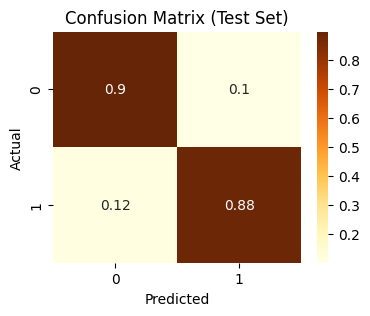

In [ ]:
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test F1 Score: {test_results['f1_score']:.4f}")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(test_results['true_labels'], test_results['predictions'],
                          target_names=['Not Duplicate', 'Duplicate']))

# Confusion Matrix
plt.figure(figsize=(4, 3))
cm = confusion_matrix(test_results['true_labels'],
                      test_results['predictions'],
                      normalize='true')
sns.heatmap(cm, annot=True, cmap='YlOrBr')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Prediction

In [ ]:
def predict_duplicate(question1, question2, model, tokenizer, device):
    """
    Predict if two questions are duplicates
    """
    model.eval()

    encoding = tokenizer(
        question1,
        question2,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors=None
    )

    input_ids = torch.unsqueeze(torch.tensor(encoding['input_ids']), dim=0).to(device)
    attention_mask = torch.unsqueeze(torch.tensor(encoding['attention_mask']), dim=0).to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    probability = predictions[0][1].item()  # Probability of being duplicate
    is_duplicate = probability > 0.5

    return {
        'is_duplicate': is_duplicate,
        'probability': probability,
        'confidence': max(probability, 1 - probability)
    }

# Example usage
example_q1 = "Why is beef banned in India and not pork as well?	"
example_q2 = "Is beef banned in india?"

result = predict_duplicate(example_q1, example_q2, model, tokenizer, device)
print(f"\nExample Prediction:")
print(f"Question 1: {example_q1}")
print(f"Question 2: {example_q2}")
print(f"Is Duplicate: {result['is_duplicate']}")
print(f"Probability: {result['probability']:.4f}")
print(f"Confidence: {result['confidence']:.4f}")


Example Prediction:
Question 1: Why is beef banned in India and not pork as well?	
Question 2: Is beef banned in india?
Is Duplicate: False
Probability: 0.0942
Confidence: 0.9058


In [ ]:
experiment_results = joblib.load(os.path.join(DATA_PATH, 'experiment_results.joblib'))

In [ ]:
results = {}
results['model'] = 'BERT Fine-Tuning'
results['log_loss_train'] = np.round(train_losses[-1], 5)
results['log_loss_val'] = np.round(val_losses[-1], 5)

experiment_results.append(results)

In [ ]:
joblib.dump(experiment_results,
            os.path.join(DATA_PATH, 'experiment_results.joblib'))

['/content/drive/MyDrive/quora_duplicate_questions/data/processed/experiment_results.joblib']